In [2]:
import numpy as np
import pymc3 as pm
from theano import shared
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from scipy import stats

In [3]:
d = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/rugged.csv", sep = ";")

d["log_gdp"] = np.log(d.rgdppc_2000)
d = d.dropna(axis = 0, subset = ["log_gdp"])

d["log_gdp_std"] = d["log_gdp"] / np.mean(d["log_gdp"])
d["rugged_std"] = d["rugged"]/np.max(d["rugged"]) 

[]

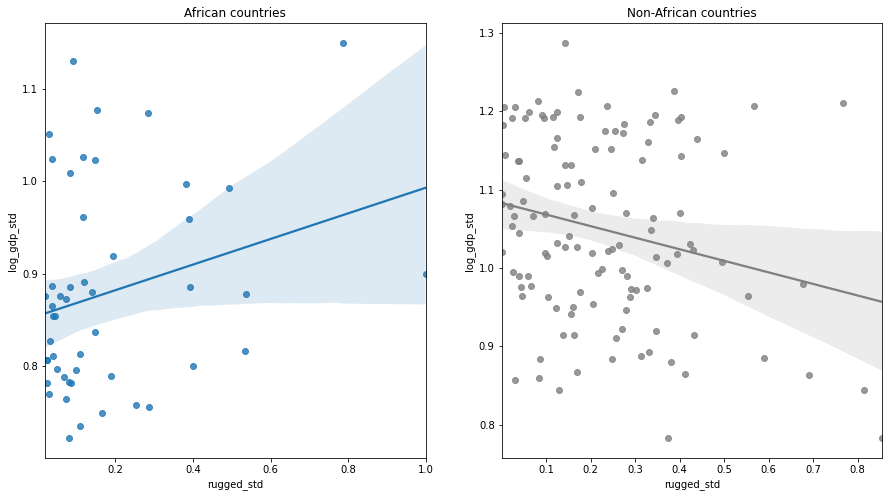

In [4]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

sns.regplot(d.loc[d.cont_africa==1, "rugged_std"], d.loc[d.cont_africa==1, "log_gdp_std"], ax=ax[0])
sns.regplot(d.loc[d.cont_africa==0, "rugged_std"], d.loc[d.cont_africa==0, "log_gdp_std"], ax=ax[1], color = "grey")

ax[0].set_title("African countries")
ax[1].set_title("Non-African countries")

plt.plot()

$log(y_i) \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_i(r_i - \hat{r})$ 

$\alpha \sim Normal(1, 1)$

$\beta \sim Normal(0, 1)$

In [5]:
m8_1a = pm.Model()
R = shared(d.rugged_std.values)
R_hat = np.mean(d.rugged_std)

with m8_1a:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 1)
    bR = pm.Normal("bR", 0, 1)
    mu = pm.Deterministic("mu", alpha + bR * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_1a_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [6]:
with m8_1a:
    m8_1_prior = pm.sample_prior_predictive()

x_seq = np.linspace(0,1,num=m8_1_a.shape[0])

m8_1_a = m8_1_prior["alpha"]
m8_1_b = m8_1_prior["bR"]

NameError: name 'm8_1_a' is not defined

In [71]:
np.sum(np.abs(m8_1_b) > 0.6) / m8_1_b.shape[0]

0.538

$\alpha \sim Normal(1, 0.1)$

$\beta \sim Normal(0, 0.3)$

In [125]:
with pm.Model() as m8_1b:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 0.1)
    bR = pm.Normal("bR", 0, 0.3)
    mu = pm.Deterministic("mu", alpha + bR * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_1b_trace = pm.sample()

with m8_1b:
    m8_1b_prior = pm.sample_prior_predictive()

m8_1b_a = m8_1b_prior["alpha"]
m8_1b_b = m8_1b_prior["bR"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


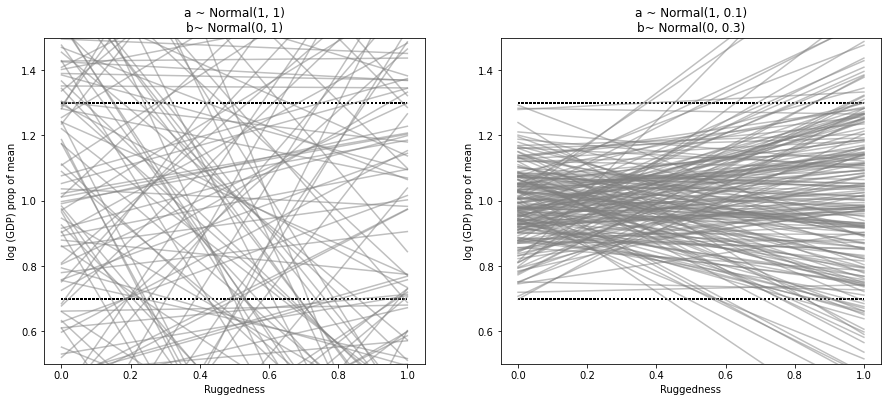

In [126]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

for i in range(200):
    ax[0].plot(x_seq, m8_1_a[i] + m8_1_b[i] * (x_seq - R_hat), color = "grey", alpha = 0.5)
    ax[0].set_ylim(0.5, 1.5)
    ax[0].hlines(1.3, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[0].hlines(0.7, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[0].set_title("a ~ Normal(1, 1)\nb~ Normal(0, 1)")
    ax[0].set_xlabel("Ruggedness")
    ax[0].set_ylabel("log (GDP) prop of mean")
for i in range(200):
    ax[1].plot(x_seq, m8_1b_a[i] + m8_1b_b[i] * (x_seq - R_hat), color = "grey", alpha = 0.5)
    ax[1].set_ylim(0.5, 1.5)
    ax[1].hlines(1.3, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[1].hlines(0.7, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[1].set_title("a ~ Normal(1, 0.1)\nb~ Normal(0, 0.3)")
    ax[1].set_xlabel("Ruggedness")
    ax[1].set_ylabel("log (GDP) prop of mean")

In [127]:
az.summary(m8_1b_trace, kind = "stats", round_to=2, var_names = ["alpha", "bR", "sigma"])

,mean,sd,hdi_3%,hdi_97%
alpha,1.00,0.01,0.98,1.02
bR,0.00,0.06,-0.10,0.11
sigma,0.14,0.01,0.12,0.15


In [205]:
# set categorical variable
cid = pd.Categorical(d.cont_africa)

with pm.Model() as m8_2:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 0.1, shape = 2)
    bR = pm.Normal("bR", 0, 0.3)
    mu = pm.Deterministic("mu", alpha[cid] + bR * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [206]:
az.compare({"m8_1_b": m8_1b_trace, "m8_2": m8_2_trace}, ic = "waic", scale = "deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_2,0,-251.983,4.28007,0,0.999971,13.0537,0,True,deviance
m8_1_b,1,-180.605,6.40857,71.3774,2.91145e-05,14.7825,14.8832,False,deviance


In [207]:
az.summary(m8_2_trace, kind = "stats", var_names = ["alpha", "bR", "sigma"])

,mean,sd,hdi_3%,hdi_97%
alpha[0],1.049,0.011,1.031,1.070
alpha[1],0.881,0.016,0.852,0.913
bR,-0.046,0.047,-0.129,0.048
sigma,0.114,0.007,0.103,0.126


In [145]:
d_a = m8_2_trace["alpha"][:,1] - m8_2_trace["alpha"][:,0]
az.summary(d_a, kind = "stats", hdi_prob = 0.97)

,mean,sd,hdi_1.5%,hdi_98.5%
x,-0.169,0.02,-0.214,-0.129


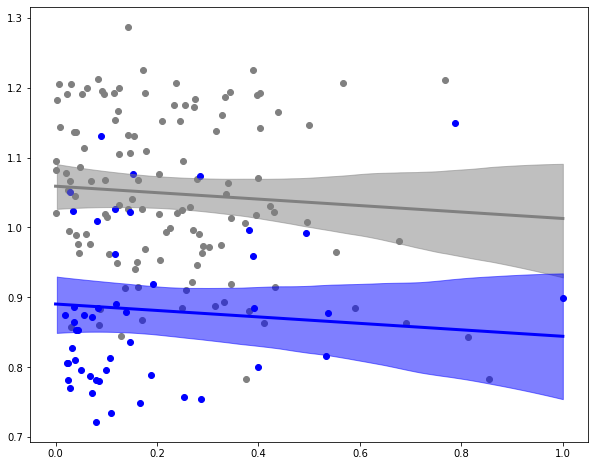

In [223]:
x_seq = np.linspace(0, 1, num=m8_2_trace["bR"].shape[0])

fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(d.rugged_std[cid ==0], d.log_gdp_std[cid ==0], color = "grey")
ax.scatter(d.rugged_std[cid ==1], d.log_gdp_std[cid ==1], color = "blue")

pred0 = m8_2_trace["alpha"][:,0] + m8_2_trace["bR"] * (x_seq - R_hat).reshape(-1,1)
pred1 = m8_2_trace["alpha"][:,1] + m8_2_trace["bR"] * (x_seq - R_hat).reshape(-1,1)

ax.plot(x_seq, m8_2_trace["alpha"][:,0].mean() + m8_2_trace["bR"].mean() * (x_seq - R_hat), color = "grey", linewidth = 3)
az.plot_hdi(x_seq, pred0.T, hdi_prob=0.97, color="grey", ax = ax)
ax.plot(x_seq, m8_2_trace["alpha"][:,1].mean() + m8_2_trace["bR"].mean() * (x_seq - R_hat), linewidth = 3, color = "blue")
az.plot_hdi(x_seq, pred1.T, hdi_prob=0.97, color="blue", ax = ax)
plt.show()

In [239]:
with pm.Model() as m8_3:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 0.1, shape = 2)
    bR = pm.Normal("bR", 0, 0.3, shape = 2)
    mu = pm.Deterministic("mu", alpha[cid] + bR[cid] * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [241]:
az.summary(m8_3_trace, var_names=["alpha", "bR", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.051,0.010,1.032,1.069,0.000,0.000,8838.0,8838.0,8836.0,3386.0,1.00
alpha[1],0.886,0.016,0.857,0.917,0.000,0.000,6342.0,6342.0,6330.0,3192.0,1.00
bR[0],-0.143,0.056,-0.242,-0.034,0.001,0.001,5733.0,4987.0,5726.0,3171.0,1.00
bR[1],0.132,0.076,-0.010,0.269,0.001,0.001,6646.0,5123.0,6663.0,3189.0,1.00
sigma,0.111,0.006,0.100,0.123,0.000,0.000,5873.0,5845.0,5864.0,2696.0,1.01


In [242]:
az.compare({"m8_1_b": m8_1b_trace, "m8_2": m8_2_trace, "m8_3": m8_3_trace}, ic = "waic", scale = "deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_3,0,-259.23,4.99438,0,0.843434,13.2502,0,True,deviance
m8_2,1,-251.983,4.28007,7.24754,0.156566,14.0135,6.52188,True,deviance
m8_1_b,2,-180.605,6.40857,78.6249,4.70063e-11,13.8639,15.2689,False,deviance


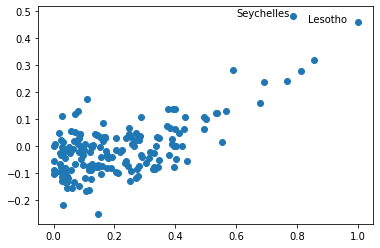

In [290]:
psis = az.loo(m8_3_trace, pointwise=True, scale="deviance")

plt.scatter(x = d.rugged_std, y = psis.pareto_k)
for i in range(0, d.shape[0]):
    if(psis.pareto_k[i] > 0.4):
        plt.text(x = d.rugged_std.values[i]-0.1, y = psis.pareto_k[i], s = d.country.values[i], ha = "center")

plt.show()

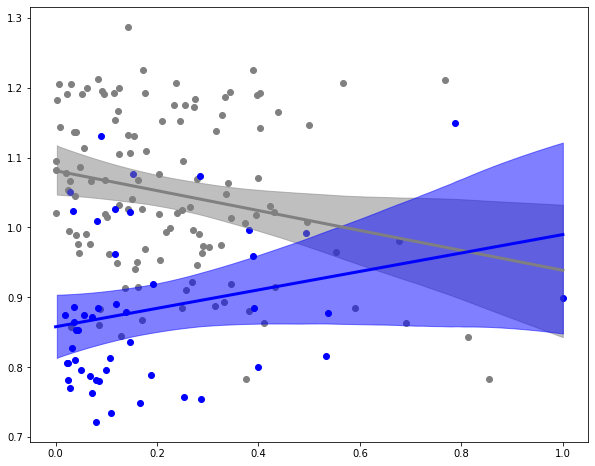

In [295]:
x_seq = np.linspace(0, 1, num=m8_3_trace["bR"].shape[0])

fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(d.rugged_std[cid ==0], d.log_gdp_std[cid ==0], color = "grey")
ax.scatter(d.rugged_std[cid ==1], d.log_gdp_std[cid ==1], color = "blue")

pred0 = m8_3_trace["alpha"][:,0] + m8_3_trace["bR"][:,0] * (x_seq - R_hat).reshape(-1,1)
pred1 = m8_3_trace["alpha"][:,1] + m8_3_trace["bR"][:,1] * (x_seq - R_hat).reshape(-1,1)

ax.plot(x_seq, m8_3_trace["alpha"][:,0].mean() + m8_3_trace["bR"][:,0].mean() * (x_seq - R_hat), color = "grey", linewidth = 3)
az.plot_hdi(x_seq, pred0.T, hdi_prob=0.97, color="grey", ax = ax)
ax.plot(x_seq, m8_3_trace["alpha"][:,1].mean() + m8_3_trace["bR"][:,1].mean() * (x_seq - R_hat), linewidth = 3, color = "blue")
az.plot_hdi(x_seq, pred1.T, hdi_prob=0.97, color="blue", ax = ax)
plt.show()

### Continuous interaction

W -> B <- S

$B_i \sim Normal(\mu_i, \sigma)$

$mu_i = \alpha + \beta_W(W+i - \hat{W}) + \beta_S(S_i - \hat{S})$

In [12]:
tulips = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/tulips.csv", sep=";")
tulips["blooms_std"] = tulips.blooms / np.max(tulips.blooms)
tulips["water_cent"] = tulips.water - np.mean(tulips.water)
tulips["shade_cent"] = tulips.shade - np.mean(tulips.shade) 

In [14]:
tulips

,bed,water,shade,blooms,blooms_std,water_cent,shade_cent
0,a,1,1,0.00,0.000000,-1.0,-1.0
1,a,1,2,0.00,0.000000,-1.0,0.0
2,a,1,3,111.04,0.307029,-1.0,1.0
3,a,2,1,183.47,0.507300,0.0,-1.0
4,a,2,2,59.16,0.163579,0.0,0.0
5,a,2,3,76.75,0.212216,0.0,1.0
6,a,3,1,224.97,0.622048,1.0,-1.0
7,a,3,2,83.77,0.231626,1.0,0.0
8,a,3,3,134.95,0.373141,1.0,1.0
9,b,1,1,80.10,0.221479,-1.0,-1.0


$\alpha \sim Normal(0.5,1)$

$\beta_W \sim Normal(0,1)$

$\beta_S \sim Normal(0,1)$

In [28]:
# alpha is too broad. Most values will be outside the theoretical boundry

N = int(1e4)
a = stats.norm.rvs(loc = 0.5, scale = 1, size = N)
print(np.sum(np.logical_or(a < 0, a > 1)) / N)

a = stats.norm.rvs(loc = 0.5, scale = 0.25, size = N)
print(np.sum(np.logical_or(a < 0, a > 1)) / N)

# if we assing prior sd of 1 to betas this means that we can expect a beta of 2 (+/- 2 sds). The range of both water and share is 2. A beta of 2 would mean that a unit increase in either variable would increase y by 2. That is clearly impossible (the range of y is 1). A beta of 0.5 could possible move y from 0 to 1 (0.5 x 2). So sd of 0.25 will mean both variables can fully explain the y variable.

0.046

In [29]:
with pm.Model() as m8_4:
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0.5, 0.25)
    bW = pm.Normal("bW", 0 , 0.25)
    bS = pm.Normal("bS", 0, 0.25)
    mu = pm.Deterministic("mu", a + bW * tulips.water_cent + bS * tulips.shade_cent.values)
    B = pm.Normal("B", mu, sigma, observed = tulips.blooms_std.values)
    m8_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, bW, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [31]:
with pm.Model() as m8_5:
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0.5, 0.25)
    bW = pm.Normal("bW", 0 , 0.25)
    bS = pm.Normal("bS", 0, 0.25)
    bWS = pm.Normal("bWS", 0, 0.25)
    mu = pm.Deterministic("mu", a + bW * tulips.water_cent + bS * tulips.shade_cent.values + bWS * tulips.water_cent * tulips.shade_cent.values)
    B = pm.Normal("B", mu, sigma, observed = tulips.blooms_std.values)
    m8_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bWS, bS, bW, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [33]:
az.summary(m8_5_trace, kind = "stats", var_names = ["a", "bW", "bS", "bWS"])

,mean,sd,hdi_3%,hdi_97%
a,0.358,0.028,0.308,0.413
bW,0.206,0.034,0.135,0.263
bS,-0.114,0.034,-0.178,-0.051
bWS,-0.142,0.041,-0.215,-0.059


In [34]:
np.repeat(0,3)

array([0, 0, 0])

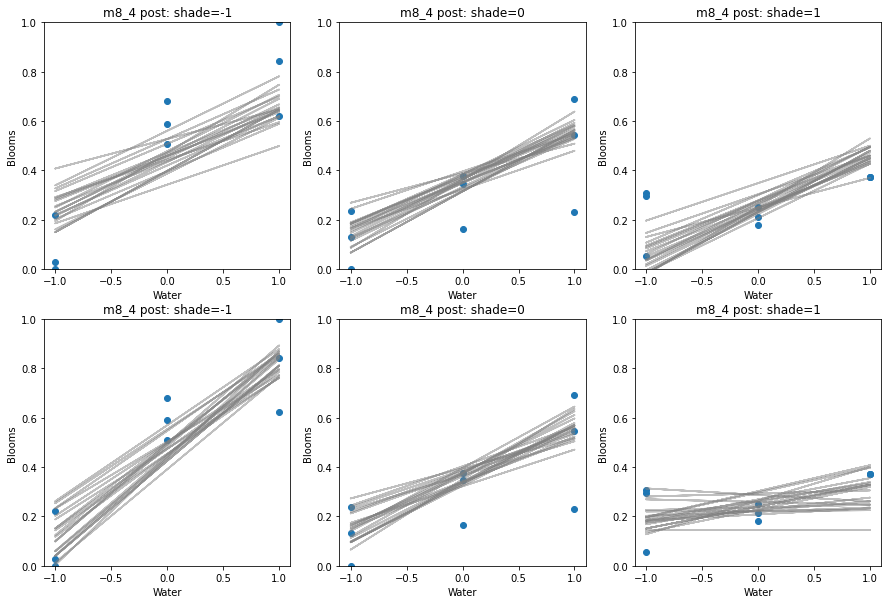

In [55]:
shade_contra = [-1,0,1]
water = [-1,0,1]

fig, ax = plt.subplots(2,3, figsize = (15,10))

for s in range(len(shade_contra)):
    d_aux = tulips.loc[tulips.shade_cent == shade_contra[s], :]
    ax[0,s].scatter(d_aux.water_cent,d_aux.blooms_std.values)
    ax[0,s].set_ylim(0,1)
    ax[0,s].set_xlabel("Water")
    ax[0,s].set_ylabel("Blooms")
    ax[1,s].scatter(d_aux.water_cent,d_aux.blooms_std.values)
    ax[1,s].set_ylim(0,1)
    ax[1,s].set_xlabel("Water")
    ax[1,s].set_ylabel("Blooms")    
    for n in range(20):
        y_hat = m8_4_trace["a"][n] + m8_4_trace["bW"][n] * d_aux.water_cent + m8_4_trace["bS"][n] * d_aux.shade_cent
        ax[0,s].plot(d_aux.water_cent, y_hat, color = "grey", alpha = 0.5)
        ax[0,s].set_title("m8_4 post: shade={}".format(shade_contra[s]))
    for x in range(20):
        y_hat = m8_5_trace["a"][x] + m8_5_trace["bW"][x] * d_aux.water_cent + m8_5_trace["bS"][x] * d_aux.shade_cent + m8_5_trace["bWS"][n] * d_aux.water_cent * d_aux.shade_cent
        ax[1,s].plot(d_aux.water_cent, y_hat, color = "grey", alpha = 0.5)
        ax[1,s].set_title("m8_5 post: shade={}".format(shade_contra[s]))

# negative interaction beta means the the slope of water to blooms decreases with increasing shade in m8_5

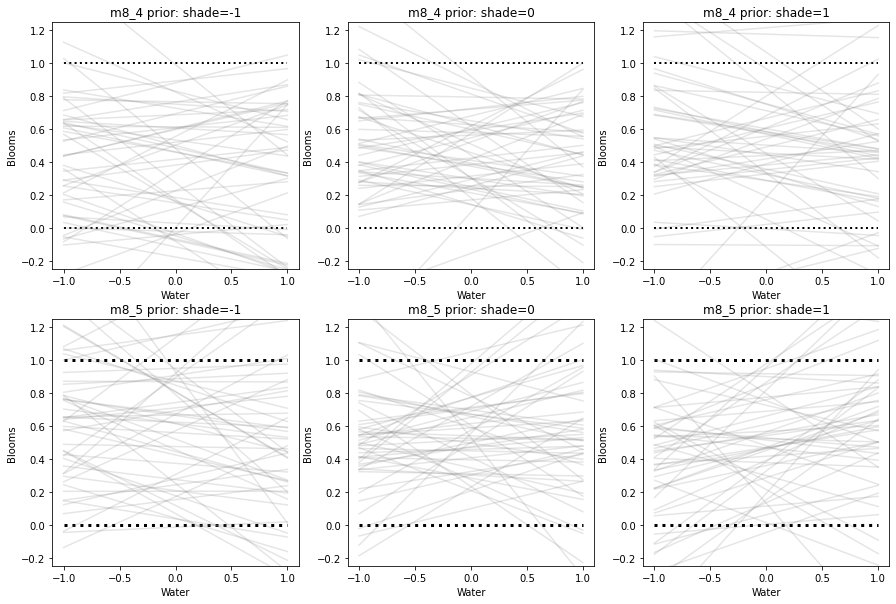

In [72]:
with m8_4:
    m8_4_prior = pm.sample_prior_predictive()

with m8_5:
    m8_5_prior = pm.sample_prior_predictive()

shade_contra = np.arange(-1,2)
water = np.arange(-1,2)

fig, ax = plt.subplots(2,3, figsize = (15,10))

for s in range(len(shade_contra)):
    d_aux = tulips.loc[tulips.shade_cent == shade_contra[s], :]
    ax[0,s].set_ylim(-0.25,1.25)
    ax[0,s].set_xlabel("Water")
    ax[0,s].set_ylabel("Blooms")
    ax[0,s].hlines(1, -1, 1, linestyle = ":", color = "black", linewidth = 2)
    ax[0,s].hlines(0, -1, 1, linestyle = ":", color = "black", linewidth = 2)
    #second plot
    ax[1,s].set_ylim(-0.25,1.25)
    ax[1,s].set_xlabel("Water")
    ax[1,s].set_ylabel("Blooms")
    ax[1,s].hlines(1, -1, 1, linestyle = ":", color = "black", linewidth = 3)
    ax[1,s].hlines(0, -1, 1, linestyle = ":", color = "black", linewidth = 3)
        
    for n in range(50):
        y_hat = (
            m8_4_prior["a"][n] + 
            m8_4_prior["bW"][n] * water + 
            m8_4_prior["bS"][n] * np.repeat(shade_contra[s], len(water))
        )
        ax[0,s].plot(water, y_hat, color = "grey", alpha = 0.2)
        ax[0,s].set_title("m8_4 prior: shade={}".format(shade_contra[s]))
    for x in range(50):
        y_hat = (
            m8_5_prior["a"][x] + 
            m8_5_prior["bW"][x] * water + 
            m8_5_prior["bS"][x] * np.repeat(shade_contra[s], len(water)) + 
            m8_5_prior["bWS"][n] * water * np.repeat(shade_contra[s], len(water))
        )
        ax[1,s].plot(water, y_hat, color = "grey", alpha = 0.2)
        ax[1,s].set_title("m8_5 prior: shade={}".format(shade_contra[s]))

# negative interaction beta means the the slope of water to blooms decreases with increasing shade in m8_5

In [70]:
(m8_4_prior["a"][n] + 
            m8_4_prior["bW"][n] * water + 
            m8_4_prior["bS"][n] * np.repeat(shade_contra[s], len(water))
        )

array([ 0.29953346,  0.06698993, -0.16555359])

## Exercise

In [100]:
#8H6
wines = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Wines2012.csv", sep = ";")

#change last 2 col names
wines.rename(columns = {"wine.amer": "wine_amer", "judge.amer": "judge_amer"}, inplace = True)


#categorical
wines["flight"] = pd.Categorical(wines.flight)

#standardize
wines["score"] = (wines["score"] - wines["score"].mean()) / wines["score"].std() 

wines.head()

,judge,flight,wine,score,wine_amer,judge_amer
0,Jean-M Cardebat,white,A1,-1.576604,1,0
1,Jean-M Cardebat,white,B1,-0.450458,1,0
2,Jean-M Cardebat,white,C1,-0.075076,0,0
3,Jean-M Cardebat,white,D1,0.300306,0,0
4,Jean-M Cardebat,white,E1,-2.327368,1,0


[]

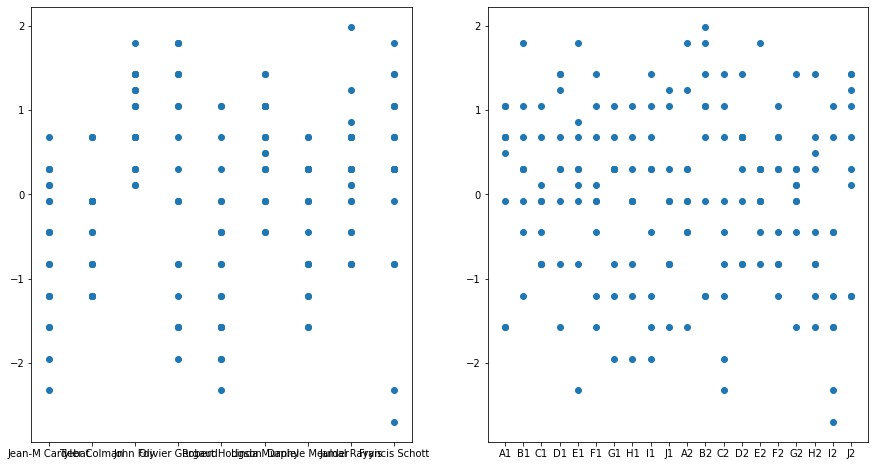

In [102]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

ax[0].scatter(wines.judge, wines.score)
ax[1].scatter(wines.wine, wines.score)
plt.plot()

In [103]:
wines.groupby(wines.judge).score.mean()

judge
Daniele Meulder   -0.319075
Francis Schott     0.243998
Jamal Rayyis       0.234614
Jean-M Cardebat   -0.619380
John Foy           0.910301
Linda Murphy       0.544304
Olivier Gergaud    0.150153
Robert Hodgson    -0.750764
Tyler Colman      -0.394151
Name: score, dtype: float64

In [104]:
wines.groupby(wines.wine).score.mean()

wine
A1    0.154324
A2    0.112615
B1    0.300306
B2    0.613124
C1   -0.137640
C2   -0.408749
D1    0.321160
D2    0.300306
E1    0.091760
E2    0.133469
F1   -0.012513
F2   -0.033367
G1   -0.116785
G2    0.008342
H1   -0.241913
H2   -0.221058
I1   -0.158495
I2   -0.950968
J1   -0.179349
J2    0.425433
Name: score, dtype: float64

In [116]:
# prior 0.5 for each so that if one type we can go from -3 to 3 (+/- 3sd) which covers most values of score
with pm.Model() as h_6:
    sigma = pm.Exponential("sigma", 1)
    bJ = pm.Normal("bJ", 0, 0.5, shape = 2)
    bW = pm.Normal("bW", 0, 0.5, shape = 2)
    bWT = pm.Normal("bWT", 0, 0.5, shape = 2)
    mu = pm.Deterministic("mu", bJ[wines.wine_amer] + bW[wines.judge_amer] + bWT[wines.flight.cat.codes])
    S = pm.Normal("S", mu, sigma, observed = wines.score.values)
    h_6_trace = pm.sample()
    h_6_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bWT, bW, bJ, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


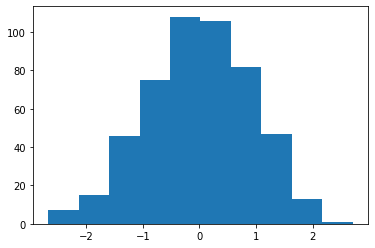

In [117]:
bJ = h_6_prior["bJ"]
bW = h_6_prior["bW"]
bWT = h_6_prior["bWT"]

# example of no amer judge, not amer wine and red wine
y_hat = bJ[:,0] + bW[:,0] + bWT[:,0]
plt.hist(y_hat)
plt.show()

In [129]:
# 0 is red
az.summary(h_6_trace, kind="stats", var_names = ["bJ", "bW", "bWT", "sigma"])

KeyError: 'var names: "[\'bC\'] are not present" in dataset'

In [131]:
# create the features for the indicator functions
cond0 = (wines["wine_amer"] == wines["judge_amer"]) + 0  # american wine and american judge
cond1 = (wines["judge_amer"] == 0) & (wines.flight.cat.codes == 1)  # french judge and white wine
cond2 = (wines["wine_amer"] == 0) & (wines.flight.cat.codes == 1)  # french wine and white wine

with pm.Model() as h_7:
    sigma = pm.Exponential("sigma", 1)
    bJ = pm.Normal("bJ", 0, 0.5, shape = 2)
    bW = pm.Normal("bW", 0, 0.5, shape = 2)
    bWT = pm.Normal("bWT", 0, 0.5, shape = 2)
    bC = pm.Normal("bC", 0, 0.5, shape = 3)
    mu = pm.Deterministic("mu", bJ[wines.wine_amer] + 
                                    bW[wines.judge_amer] + 
                                    bWT[wines.flight.cat.codes] + 
                                    bC[0] * cond0 +
                                    bC[1] * cond1 + 
                                    bC[2] * cond2)
    S = pm.Normal("S", mu, sigma, observed = wines.score.values)
    h_7_trace = pm.sample()
    h_7_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bC, bWT, bW, bJ, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [132]:
# 0 is red
az.summary(h_7_trace, kind="stats", var_names = ["bJ", "bW", "bWT", "bC", "sigma"])

,mean,sd,hdi_3%,hdi_97%
bJ[0],0.222,0.314,-0.386,0.803
bJ[1],-0.144,0.310,-0.765,0.424
bW[0],-0.092,0.317,-0.696,0.477
bW[1],0.167,0.308,-0.392,0.751
bWT[0],-0.029,0.313,-0.596,0.568
bWT[1],0.120,0.322,-0.477,0.729
bC[0],-0.052,0.143,-0.330,0.207
bC[1],0.020,0.249,-0.407,0.529
bC[2],-0.395,0.245,-0.850,0.077
sigma,0.995,0.053,0.898,1.095


In [125]:
# create the features for the indicator functions
cond0 = (wines["wine_amer"] == wines["judge_amer"]) + 0  # american wine and american judge
cond1 = (wines["judge_amer"] == 0) & (wines.flight.cat.codes == 1)  # french judge and white wine
cond2 = (wines["wine_amer"] == 0) & (wines.flight.cat.codes == 1)  # french wine and white wine
